In [1]:
'''
Krotov Algorithm for Quantum gate Implementation
Written By Bilal Riaz

'''
import matplotlib
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.random as rnd
import scipy.linalg as LA
from scipy.integrate import ode


class Krotov:
    def __init__(self,w,  lambd, gamma_dephasing, gamma_relaxation, ti,tf,steps):
        self.w = float(w)
        self.ti = ti
        self.tf = tf
        self.steps = steps
        self.t = np.linspace(ti,tf,steps)
        self.lambd = lambd
        
        rnd.seed(2)

        self.dt = self.t[1] - self.t[0]
        self.sX = np.array([[0, 1], [1, 0]], dtype = 'complex128')
        self.sY = np.array([[0, -1j], [1j, 0]], dtype = 'complex128')
        self.sZ = np.array([[1, 0], [0, -1]], dtype = 'complex128')
        self.I = np.array(np.identity(2), dtype = 'complex128')
        self.sD = np.array([[0, 1],[0, 0]], dtype = 'complex128')
        self.ssD = np.kron(self.sD, self.sD)

        # Decoeherence Parameters
        self.gamma_deph = gamma_dephasing
        self.gamma_relax = gamma_relaxation


        self.delta = 2.0
        self.deltap = 2.0
        self.alpha = 2.0

       # seed is given values for better debugging and Design Purposes
        #   

        #omega = 0.1

        # Controls

        self.EX = 1 * ( rnd.rand(self.steps,) - 0.5)
        self.EX_tilde = np.zeros((self.steps,))

        self.Ui = np.identity(2, dtype = 'complex128')
        self.UT = -1j*np.array([[0, 1], [1, 0]], dtype = 'complex128')

        # self.U = np.zeros([self.steps, 2, 2], dtype = 'complex128')
        # self.B = np.zeros([self.steps, 2, 2], dtype = 'complex128')

        self.Gi = np.kron(self.Ui, self.Ui)
        self.GT = np.kron(self.UT.conj(), self.UT)


        # self.U[0] = np.identity(2, dtype = 'complex128')
        # self.B[steps - 1] = self.UT.T.conj()
        self.G = np.zeros([self.steps, 4, 4], dtype = 'complex128')
        self.B = np.zeros([self.steps, 4, 4], dtype = 'complex128')

        self.G[0] = np.kron(self.Ui.conj(), self.Ui)
        self.B[steps - 1] = (np.kron(self.UT, self.UT.conj())).T.conj()


        self. Ho = self.w * self.sZ
        
        
   # Lindlbladian superoperator to study open dynamcis of quantum systems

    def Gamma(self, C):
        return( np.kron(C.conj(), C) - \
          (1.0/2.0) * np.kron(self.I, C.conj().T @ C) - (1.0/2.0) * np.kron (C.T@C.conj(), self.I) )

    # vec() notation based operator for liovillian operator for vectorized density matrix

    def ad(self, C):
        L =  np.kron(self.I, C) - np.kron(C.T, self.I)
        return (L)

    #  K operator is sum of lioviellian and Lindbladian
    def K (self, t):
        return (-1j * self.ad(self.H(t))  + self.gamma_deph * self.Gamma(self.sD) + self.gamma_relax * self.Gamma(self.sD))

    def K_tilde (self, t):
        return (-1j * self.ad(self.H_tilde(t))  + self.gamma_deph * self.Gamma(self.sD) + self.gamma_relax * self.Gamma(self.sD))

    def Hc(self, t_index):
        t = t_index
        return (self.EX[t] * self.sX )

    def Hc_tilde(self, t_index):
        t = t_index
        return (self.EX_tilde[t] * self.sX )

    def H(self, t_index):
        t = t_index
        return (self.Ho + self.Hc(t))

    def H_tilde(self, t_index):
        t = t_index
        return (self. Ho + self.Hc_tilde(t))

    def update_G (self, t_index):
        t = t_index
        self.G[t+1] = np.dot(LA.expm( self.K(t) * self.dt), self.G[t])

    def update_B (self, t_index):
        t = t_index
        self.B[t-1] = np.dot( self.B[t], LA.expm( self.K_tilde(t) * self.dt))

    def update_E(self, t_index):
        t=t_index

#         EX_part1 = (1-self.delta) * self.EX_tilde[t-1]
#         EX_part2 = -self.delta * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.ad(self.sX), self.G[t]) ) ) )/ self.alpha
#         self.EX[t] = -(EX_part1 + EX_part2)
        
        EXpart1 = (1-self.delta) * self.EX_tilde[t-1]
        EXpart2 = -self.delta * self.lambd * np.imag( np.trace(np.dot(self.B[t-1], np.dot( self.ad(self.sX), self.G[t]) ) ) )/ self.alpha
        self.EX[t] = -(EXpart1 + EXpart2)


    def update_E_tilde(self,t_index):
        t=t_index

#         EX_part1 = (1 - self.deltap) * self.EX[t]
#         EX_part2 = -self.deltap *  np.imag( np.trace(np.dot(self.B[t], np.dot( self.ad(self.sX), self.G[t]) ) ) )/ self.alpha
#         self.EX_tilde[t] = -(EX_part1 + EX_part2)
        
        EXpart1 = (1-self.delta) * self.EX[t]
        EXpart2 = -self.delta * self.lambd * np.imag( np.trace(np.dot(self.B[t], np.dot( self.ad(self.sX), self.G[t]) ) ) )/ self.alpha
        self.EX_tilde[t] = -(EXpart1 + EXpart2)

    def evolution_G(self,string='not initial'):
        if string == 'initial':
            for t in range(0,self.steps-1):
                self.update_G(t)
        else:
            for t in range(0,self.steps-1):
                self.update_E(t)
                self.update_G(t)
            t = self.steps-1
            self.update_E(t)

    def evolution_B(self):
        for t in range(self.steps-1,0,-1):
            self.update_E_tilde(t)
            self.update_B(t)
        t = 0
        self.update_E_tilde(t)

    def O(self,step):
        t = step
        return( np.dot(self.GT.conj().T, self.G[t] ))

    # Some methods might seem redundant but they are maintained to solve complicated optimal control problems in future
    # Better Structured Toolboxes can give

    def Overlap(self, t_index ):
        t = t_index
        return( np.abs(np.trace(self.O(t))))

    def distance(self,t_index):
        t= t_index
        return(LA.norm(self.GT - self.G[t], 'fro'))

    def Run_Krotov(self, num_iter):
        T = self.steps-1
        
        self.overlap = np.zeros([num_iter + 1, 1], dtype = 'float64')
        self.dis = np.zeros([num_iter + 1, 1], dtype = 'float64')
        
        self.overlap[0] = self.Overlap(T)
        self.dis[0] = self.distance(T)
        
        self.evolution_G('initial')
#         self.overlap = np.zeros([num_iter,1], dtype = 'float64')
#         self.dis = np.zeros([num_iter,1], dtype = 'float64')

        for i in range(0,num_iter):
            #print (str(self.overlap[i]))
            self.B[T] = self.GT.conj().T
            self.evolution_B()
            self.evolution_G()
            self.overlap[i + 1] = self.Overlap(T)
            self.dis[i + 1] = self.distance(T)
            print ("Cycle : " + str(i) + ", infidelity = " + str(1-np.abs(self.overlap[i])/4))



if __name__ == '__main__':
    # INTITIALIZE :
    # self,w, lambd, gamma_dephasing, gamma_relaxation, ti,tf,steps
    k = Krotov(0.1, 5e-1, 0 , 0 , 0,  2, 10000)
    k.Run_Krotov(200)

    plt.figure(1)
    plt.title('Overlap Vs Iteration')
    plt.ylabel('Overlap')
    plt.xlabel('Iteration')
    plt.semilogy(1-np.abs(k.overlap)/4)
    plt.show()

Cycle : 0, infidelity = [1.]
Cycle : 1, infidelity = [0.00586999]
Cycle : 2, infidelity = [0.00568187]
Cycle : 3, infidelity = [0.00549809]
Cycle : 4, infidelity = [0.00532071]
Cycle : 5, infidelity = [0.00514679]
Cycle : 6, infidelity = [0.00497898]
Cycle : 7, infidelity = [0.00481553]
Cycle : 8, infidelity = [0.00465621]
Cycle : 9, infidelity = [0.0045012]
Cycle : 10, infidelity = [0.00435145]
Cycle : 11, infidelity = [0.00420567]
Cycle : 12, infidelity = [0.00406473]
Cycle : 13, infidelity = [0.00392819]
Cycle : 14, infidelity = [0.00379504]
Cycle : 15, infidelity = [0.0036661]
Cycle : 16, infidelity = [0.00354125]
Cycle : 17, infidelity = [0.00342025]
Cycle : 18, infidelity = [0.00330392]
Cycle : 19, infidelity = [0.0031905]
Cycle : 20, infidelity = [0.00308016]
Cycle : 21, infidelity = [0.00297441]
Cycle : 22, infidelity = [0.00287098]
Cycle : 23, infidelity = [0.0027717]
Cycle : 24, infidelity = [0.0026758]
Cycle : 25, infidelity = [0.00258258]
Cycle : 26, infidelity = [0.0024924

In [4]:
# Now exporting variables to matlab to have comparsion with GRAPE and other standard Implementations


import scipy.io as sio


Krotov_data = { };
Krotov_data['w'] = k.w
Krotov_data['lambd'] = k.lambd 
Krotov_data['ti'] = k.ti
Krotov_data['tf'] = k.tf
Krotov_data['steps'] = k.steps
Krotov_data['t'] = k.t
Krotov_data['dt'] = k.dt

Krotov_data['G'] = k.G
Krotov_data['B'] = k.B

Krotov_data['Ex'] = k.EX;


Krotov_data['EX_tilde'] = k.EX_tilde;

Krotov_data['dis'] = k.dis;
Krotov_data['overlap'] = k.overlap;


Krotov_data['sI'] = k.I;
Krotov_data['sX'] = k.sX;


Krotov_data['sIZ'] = k.delta
Krotov_data['sIZ'] = k.alpha 
Krotov_data['sIZ'] = k.deltap 

            
            
sio.savemat('Krotov_1Qbit_Closed_2', Krotov_data)





In [5]:
k.distance(k.steps-1)

0.01274912906070225

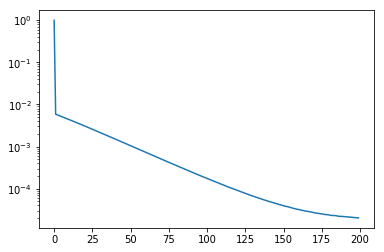

In [8]:
plt.semilogy(1-(np.abs(k.overlap[0:200]))/4)

In [9]:
1-np.abs(np.trace(np.dot (k.GT.T.conj(), k.G[k.steps-1].conj().T )))/4

2.031753661291269e-05

In [13]:
(k.G[k.steps-1])

array([[ 8.05807295e-06-2.98041341e-17j,  2.77259936e-03-6.08852021e-04j,
         2.77259936e-03+6.08852021e-04j,  9.99991942e-01+4.54251295e-17j],
       [ 2.77679498e-03-5.89421443e-04j, -7.34012872e-06+3.32491354e-06j,
         9.99967423e-01+7.00263221e-03j, -2.77679498e-03+5.89421443e-04j],
       [ 2.77679498e-03+5.89421443e-04j,  9.99967423e-01-7.00263221e-03j,
        -7.34012872e-06-3.32491354e-06j, -2.77679498e-03-5.89421443e-04j],
       [ 9.99991942e-01+2.97397680e-17j, -2.77259936e-03+6.08852021e-04j,
        -2.77259936e-03-6.08852021e-04j,  8.05807295e-06-4.53718860e-17j]])

In [11]:
np.vdot(k.G[k.steps-1],k.G[k.steps-1])

(3.999999999998903+0j)

In [12]:
np.dot(k.G[k.steps - 1], k.G[k.steps - 1])

array([[ 9.99998564e-01+4.61318520e-17j,  4.19960057e-06+1.19827259e-03j,
         4.19960057e-06-1.19827259e-03j,  1.43587694e-06-4.63902803e-17j],
       [-4.19163225e-06+1.19827262e-03j,  9.99998564e-01-6.64982231e-06j,
         1.43584165e-06+1.00549987e-08j,  4.19163226e-06-1.19827262e-03j],
       [-4.19163225e-06-1.19827262e-03j,  1.43584165e-06-1.00549984e-08j,
         9.99998564e-01+6.64982231e-06j,  4.19163226e-06+1.19827262e-03j],
       [ 1.43587694e-06-4.65540041e-17j, -4.19960056e-06-1.19827259e-03j,
        -4.19960056e-06+1.19827259e-03j,  9.99998564e-01+4.67901650e-17j]])